# **Injection Tutorial — KIC 10979716 (Local, Small-Grid Run)**
---

## **Background: KIC 10979716**


> **Note:** The search step in this notebook is configured as a
> brute-force grid search and can take **2-3 hours** on a
> standard laptop. This is acceptable for a narrow, prior-informed demonstration,
> but a **wider, less constrained search** (e.g. with broader period and parameter
> grids) quickly becomes computationally expensive.
>
> For any realistic, fully blind circumbinary search over large grids, we
> strongly recommend running STANLEY on a **cluster / HPC environment** rather
> than on a single local machine.

---

## **Import packages and STANLEY modules**

Below:  
- `runDetrendingModule` handles all TESS/Kepler detrending.  
- `SFP` performs the planet search.  
- `runAnalysisModule` handles post-detection diagnostics.


In [ ]:
from stanley_cbp import stanley_detrending, SFP, stanley_analysis
from stanley_cbp import Stanley_Functions as AC
import csv, os
import numpy as np
from IPython.display import Image, display

c:\Users\tklea\anaconda3\envs\stanleynew\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\Users\tklea\anaconda3\envs\stanleynew\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# **Detrending**

This notebook mirrors the structure of the cluster detrending workflow, but reorganized for clarity and interactivity in a teaching environment. The detrending stage is essential for removing binary-driven variability, instrumental systematics, and common TESS artifacts before performing a circumbinary planet search.

Goals of this section: 
- Discuss and demonstrate the capabilities of STANLEY's detrending module.
- Highlight the **key diagnostic figures** produced by STANLEY, including:
  - Raw light curve
  - Eclipse-fitting diagnostics
  - Binary-model trend removal
  - Final detrended light curve used for searching

Notebook conventions:
- Internal timing uses **seconds**, but plotted results are shown in **days**.
- All output files are written to the automatically created `LightCurves/Data_Preparation/<DetrendingName>/` and `LightCurves/Figures/<DetrendingName>/` directories.
- In this tutorial we display only the **most informative figures**, rather than every intermediate plot.


## Configuration: STANLEY Detrending Module

The detrending stage in this notebook is a thin, notebook-friendly wrapper around the full **cluster version** of the STANLEY detrending code.

In the original script, detrending is driven by **command-line arguments** and a large set of internal switches (see `runDetrendingModule` in `Stanley_Detrending.py`). Here, we expose the same functionality through a single Python function call with explicit keyword arguments.

### Core inputs

The core inputs and run labels are:

- `SystemName` *(str)*  
 Target identifier, e.g. `"TIC260128333"` or `"6762829"` for Kepler.
- `DetrendingName` *(str)*  
  Short run label; used to name figures and processed files.
- `UseSavedData` *(int: 0 or 1)*  
  - `0` → force fresh downloads and processing  
  - `1` → reuse cached light curves / intermediates when available

These map directly to the cluster script’s `--systemName`, `--detrendingName`, and `--useSavedData` arguments.


### Detrending feature switches

The following Boolean flags control which detrending steps are applied. They are identical in meaning to those in the cluster code:

- `detrending_quadratic`  
  Apply a broad quadratic trend removal (default for TESS, **enabled**).
- `detrending_iterativeCosine`  
  Run the iterative cosine (cofiam-like) detrending to remove periodic systematics. (**enabled**)
- `detrending_plugHoles`  
  Fill large gaps before variable-window detrending (optional, off by default). (**disabled**)
- `detrending_variableDuration`  
  Enable variable-duration biweight detrending using a time-varying window.(**disabled**)
- `detrending_removeKinks`  
  Identify and remove “kinks” and jump-like artifacts in the light curve. (**enabled**)
- `detrending_removeCommonFalsePositives`  
  Remove catalogued false positives (primarily for Kepler EB samples). (**enabled**)
- `detrending_findPotentialLedges`  
  Flag possible ledges for later human inspection. (**enabled**)
- `detrending_findDeepestPoints`  
  Report the deepest individual points after detrending. (**enabled**)
- `detrending_plotSpecificTimes`
  Create targeted plots around manually chosen time windows. (**disabled**)
- `detrending_saveProcessedLightCurve`  
  Save the final detrended light curve to `LightCurves/Processed/... (**enabled**)
- `detrending_variableDurationXiTest`  
  Optional diagnostic mode for the variable-duration biweight step.(**disabled**)
- `detrending_testCosine`  
  Optional diagnostic mode for the iterative cosine detrending. (**diabled**)

For this tutorial, we choose a subset of these to keep the workflow clear while
still reflecting the full pipeline’s behavior.


### Injection and binary-physics options

Additional high-level options:

- `detrending_injectTransits` *(bool)*  
  If `True`, injects synthetic transits (please see the KeplerInjectionTutorial Jupyter Notebook)
- `injection_param_file` *(str or None)*  
  Path to a CSV listing injection parameters. If omitted while injections are on,
  a mission-specific default is used.

- `detrending_ellipsoidal` *(bool)*  
  Fit and remove ellipsoidal modulation at 2× the binary orbital frequency. (**enabled**)
- `detrending_reflection` *(bool)*  
  Fit and remove reflection / heating effects at 1× the binary orbital frequency. (**enabled**)

In this notebook, we leave injections **off** and optionally enable the
binary-physics trends to illustrate their effect on the light curve.


### Plotting and binning behavior

Plot and binning controls:

- `_plot_trends`, `_show_plots` *(bool)*  
  Decide whether trend models and intermediate diagnostics are plotted. (**enabled**)
- `bin_width`, `min_points_per_bin`, `gap_threshold`  
  Control the time binning applied (for TESS) and how gaps are identified for certain stages of detrending.

All detrended light curves, periodograms, and multi-panel stage figures are written
to:

- `LightCurves/Data_Preparation/<DetrendingName>/`  
- `LightCurves/Figures/<DetrendingName>/`  
- `LightCurves/Processed/<DetrendingName>/`  

The notebook configuration below sets these options via simple Python variables rather than command-line flags, but the underlying pipeline behavior remains the same
as in the cluster script.


In [2]:
# Inputs & run label (replace these as needed)
SystemName = "KIC10979716" # KIC or TIC (e.g., "TIC 260128333" or just "260128333" depending on AC.GetID)
ID = 10979716 
mission = "KIC" # "KIC" or "TIC"
DetrendingName = "TutorialKeplerInjection10979716" # short label for figures/files
UseSavedData = 0 # 1=use cached intermediates if available, 0=fresh

# --- Feature switches ---
detrending_quadratic = False
detrending_iterativeCosine = True
detrending_plugHoles = False
detrending_variableDuration = False
detrending_removeKinks = True
detrending_removeCommonFalsePositives = True
detrending_findPotentialLedges = True
detrending_findDeepestPoints = True
detrending_plotSpecificTimes = False
detrending_saveProcessedLightCurve    = True
detrending_variableDurationXiTest = False
detrending_testCosine = False
detrending_injectTransits = True

# These were implimented primarily for data processing of TESS targets but can also run on Kepler data should you wish
# TESS targets had more variable data, iter3ative cosine seems to be sufficient for Kepler data
detrending_ellipsoidal = False
detrending_reflection  = False

# --- Plot behavior ---
_plot_trends = True
_show_plots = True

In [11]:
#generate csv for planet injection
# Ensure the directory exists
os.makedirs("../Databases", exist_ok=True)

titles = ["", "KIC", "ep", "omegap", "thetap", "Pp_days", "Rp_rEarth"]
params = [0, 10979716, 0, 0.1291298734467532, 5.092903222498788, 108.97737527999979, 6.0]

save_path = os.path.join("..", "Databases", "planet_params.csv")

with open(save_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(titles)
    writer.writerow(params)

print(f"Saved CSV to {save_path}")

In [ ]:
injection_csv = "../Databases/planet_params.csv"  # e.g., "my_injections.csv"

# Build kwargs from feature switches defined in the previous cell
kwargs = dict(
    SystemName=SystemName,
    DetrendingName=DetrendingName,
    UseSavedData=UseSavedData,

    detrending_quadratic=detrending_quadratic,
    detrending_iterativeCosine=detrending_iterativeCosine,
    detrending_plugHoles=detrending_plugHoles,
    detrending_variableDuration=detrending_variableDuration,
    detrending_removeKinks=detrending_removeKinks,
    detrending_removeCommonFalsePositives=detrending_removeCommonFalsePositives,
    detrending_findPotentialLedges=detrending_findPotentialLedges,
    detrending_findDeepestPoints=detrending_findDeepestPoints,
    detrending_plotSpecificTimes=detrending_plotSpecificTimes,
    detrending_saveProcessedLightCurve=detrending_saveProcessedLightCurve,
    detrending_variableDurationXiTest=detrending_variableDurationXiTest,
    detrending_testCosine=detrending_testCosine,
    detrending_injectTransits=detrending_injectTransits,

    detrending_ellipsoidal=detrending_ellipsoidal,
    detrending_reflection=detrending_reflection,

    _plot_trends=_plot_trends,
    _show_plots=_show_plots,
)

# Only attach the CSV arg if injections are enabled *and* you provided a filename
if detrending_injectTransits and injection_csv:
    kwargs["injection_param_file"] = injection_csv

# Fire the pipeline
res = stanley_detrending.runDetrendingModule(**kwargs)

print("Detrending finished.\nSummary:")
for k, v in res.items():
    print(f"  {k}: {v}")

LDTk downloading uncached files: 100%|██████████| 8/8 [00:13<00:00,  1.67s/it]


## Search

In [13]:

from argparse import Namespace

TotalSectors = 4
OnCluster = 0
SearchName = 'TutorialSearch_KeplerInjection10979716'
SystemName = SystemName
DetrendingName = DetrendingName
N_interp = 2
BoundsType = 'days to days'
MinValue = 95
MaxValue = 110
e_max_planet = 0.0

args = Namespace(
    searchName=SearchName,
    systemName=SystemName,
    detrendingName=DetrendingName,
    totalSectors=TotalSectors,
    currentSector=1,
    onCluster=OnCluster,
    parallel=1,
    interpolationValue=N_interp,
    boundsType=BoundsType,
    minValue=MinValue,
    maxValue=MaxValue,
    e_max_planet=e_max_planet,
)

SFP.parallel(args)

print("Search finished for all sectors (parallel).")

---
## **Analysis**

After the search has completed, we call `runAnalysisModule` to turn the high-dimensional
search outputs into a small set of **human-interpretable diagnostics**.

Conceptually, `runAnalysisModule`:

- **Loads the search context and detrended light curve**  
  using the `simInfo` file, the saved detrended CSV associated with the same `DetrendingName`,
  and the binary starting parameters.

- **Reads and aggregates the search grids**  
  by loading the `searchParameters_array` and concatenating the
  `searchResults_array_*` files in `PlanetSearchOutput/<SearchName>/`
  across all θₚ sectors.

- **Builds a 1D detection statistic as a function of planet period**  
  by combining the multi-dimensional significance grid over the remaining
  parameters (masses, binary elements, eccentricity *eₚ*, argument of periastron *ωₚ*,
  and true anomaly *θₚ*), and then computing an SDE curve vs. period.

- **Selects the best-fit model at the SDE peak**  
  and extracts the corresponding `(Pₚ, eₚ, ωₚ, θₚ)` combination, along with the
  associated binary parameters.

- **Reconstructs transit times and durations** for the best-fit configuration  
  and generates:
  - A **TTV (Transit Timing Variations)** plot  
  - A **TDV (Transit Duration Variations)** plot  
  - A concise, human-readable summary text file  
  - Helper files with transit windows and discovered transit lists for downstream vetting.

In this tutorial, we only have **one sector**, but we still use `runAnalysisModule` so that
the workflow matches the full multi-sector/cluster use case:

- The same analysis call will work if `totalSectors > 1`.  
- The module automatically discovers and loads all sector outputs associated with
  `searchName` and `systemName`.  
- The returned `result` dictionary provides a compact summary (e.g. peak SDE value
  and best-fit period) that we can inspect directly in the notebook.


In [ ]:
result = stanley_analysis.runAnalysisModule(
    searchName=SearchName,
    systemName=SystemName,
    totalSectors=TotalSectors,
    currentSector=1,
    onCluster=OnCluster,
)

print("Analysis finished.")
print("Summary:")
for k, v in result.items():
    print(f"  {k}: {v}")

[2025-12-05 11:53:04.452928] Analysis expecting simInfo at: C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\PlanetSearchOutput\TutorialSearch_KeplerInjection10979716\KIC_10979716_simInfo.npy
Loading results for searchName = TutorialSearch_KeplerInjection10979716, systemName = KIC10979716, detrendingName = TutorialKeplerInjection10979716
4 sector(s) loaded
Create 1D SDE
[SDE diag] N=307 kept=293 (95.44%) initialSTD=5.34357 clipSTD=1.34293 denom=initialSTD max=8.270
[SDE] Max=8.270 at 108.91773 d
1D SDE created
Getting best fitting transit times
we have entered the plotting statement
meanPlanetTransitInterval (sec): 9230968.77819427
scaledWindowTime size: 46, totalWindowFlux size: 46
meanScaledFlux_time size: 14, meanScaledFlux size: 14
we have made it to this point - Tess 10/16
sigma_solutionOld = 53.502904402917785
meanFlux_solution = -0.005811042270469941
No known transits file found
[create_search_analysis_diagnostic_report] Writing PDF to: C:\Users\tklea\TESSCBP\PUBLIC_RELEA


Search and analysis diagnostic plots:

Showing: 10979716_KICSDEpaper.png


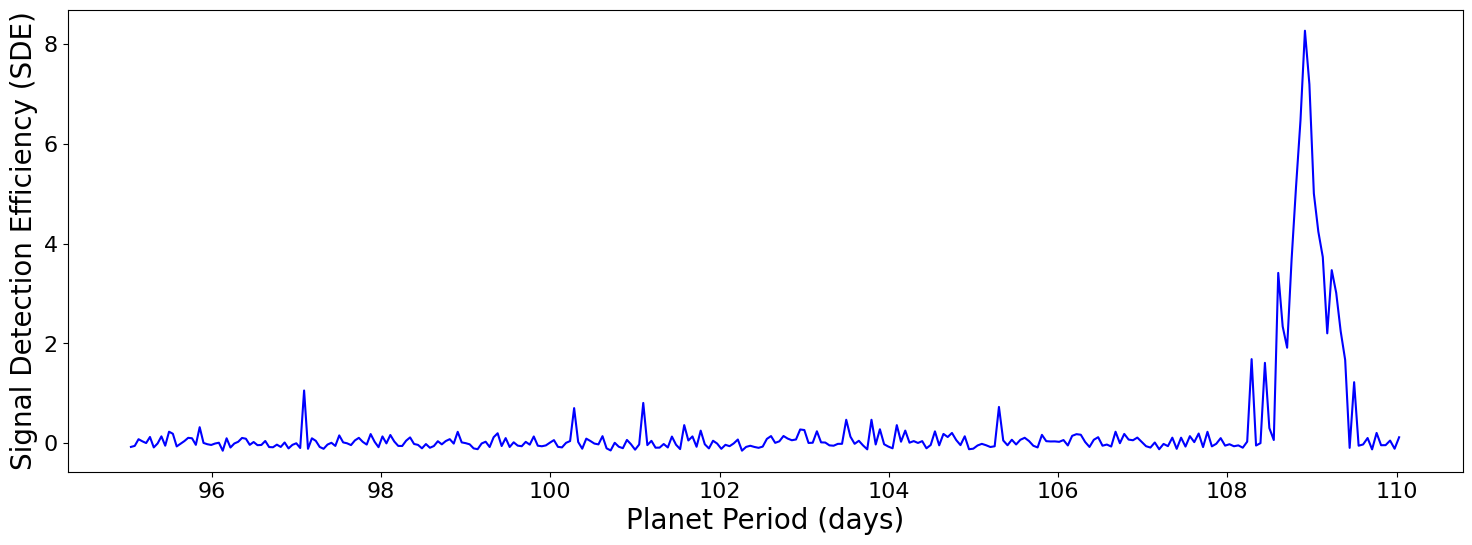

Showing: KIC_10979716_IndividualPlanetTransitsWiderWindow.png


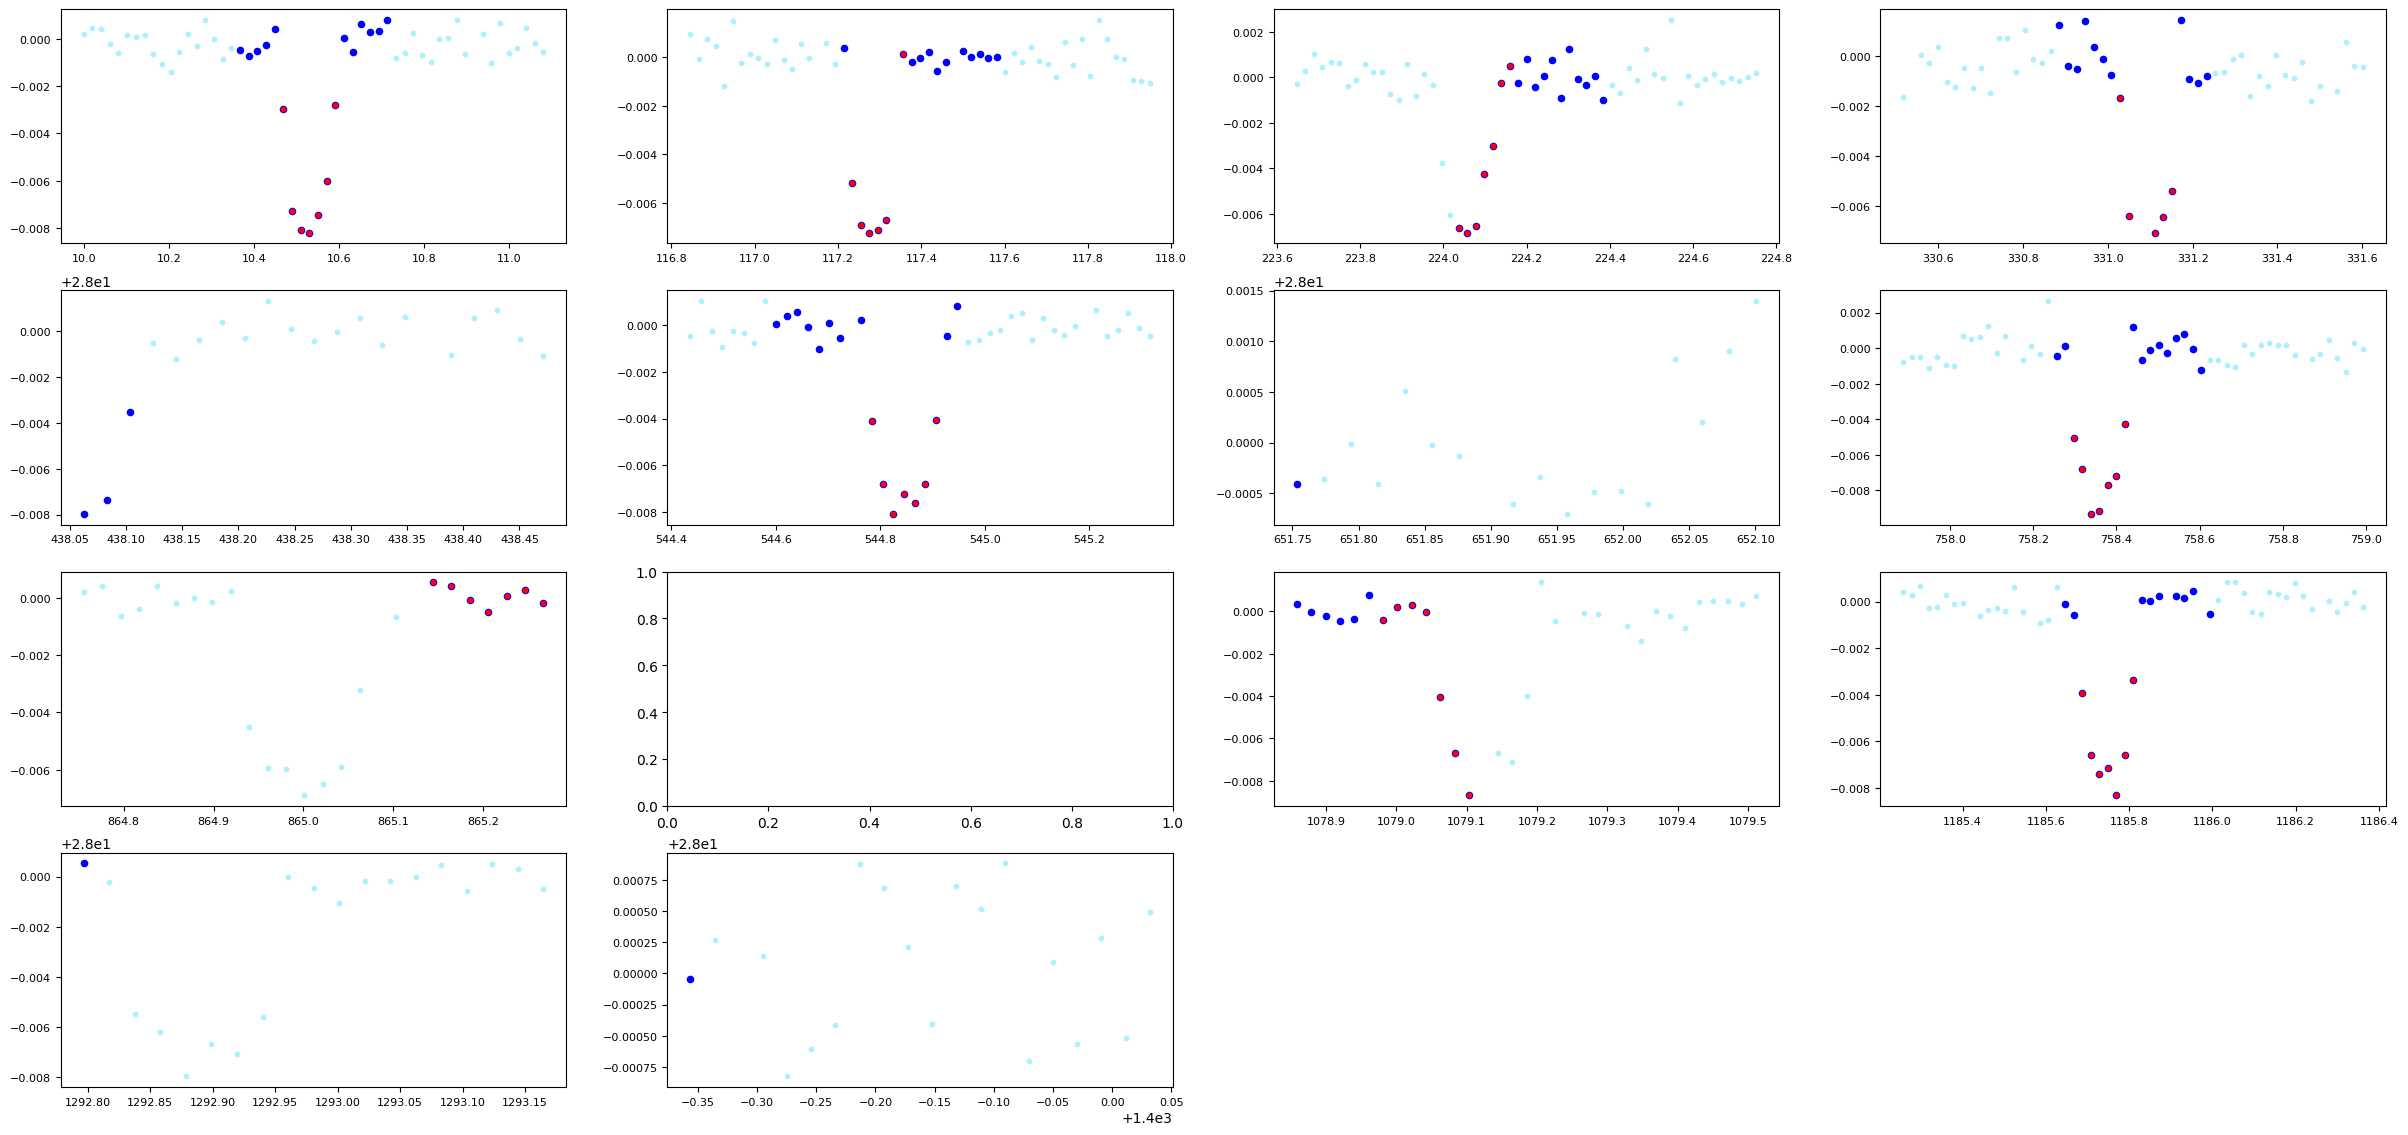

Showing: KIC_10979716_FoldedPlanetTransits.png


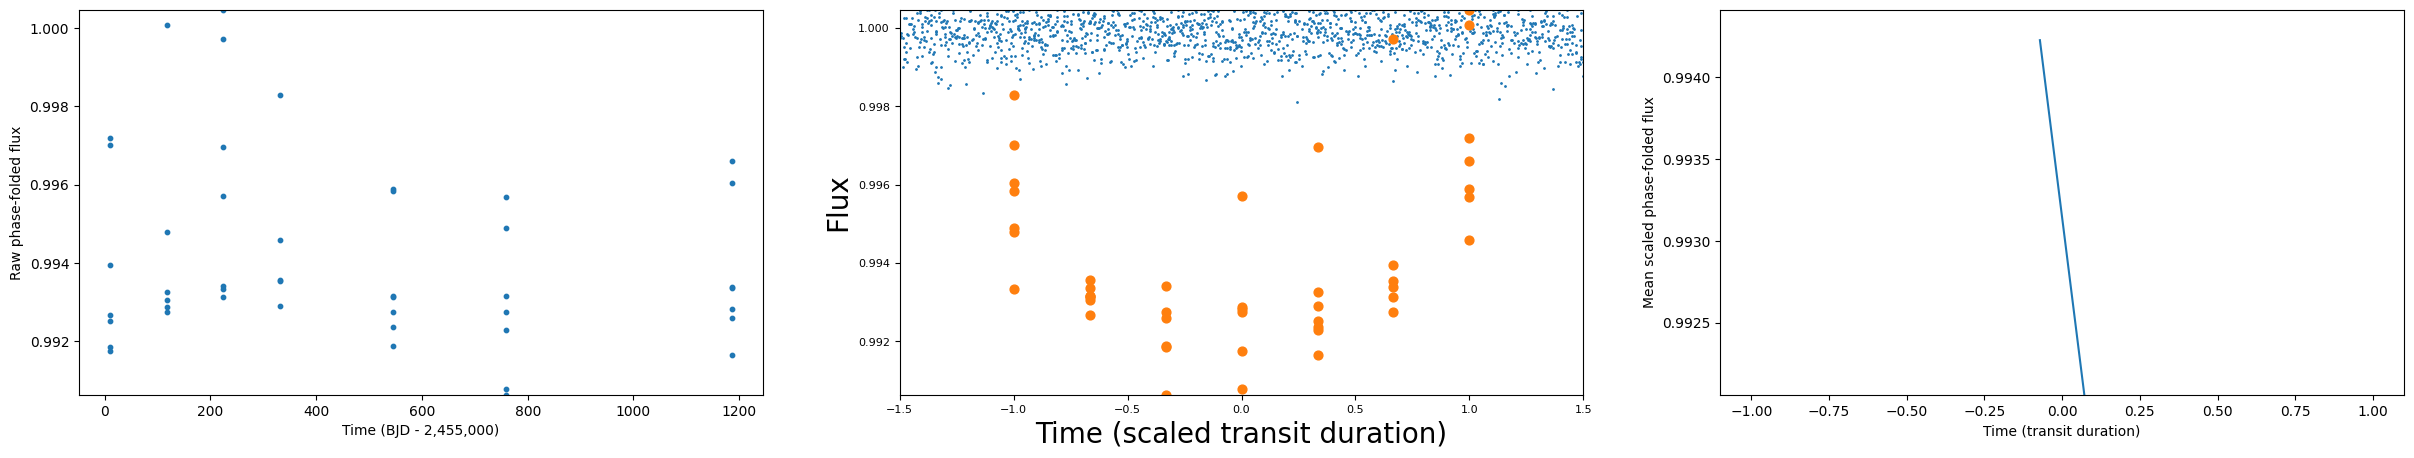



         Search Summary

System name                   : KIC10979716
mission + ID                  : KIC_10979716
Search name                   : TutorialSearch_KeplerInjection10979716
Detrending name               : TutorialKeplerInjection10979716
Total sectors                 : 4
Num Theta_p steps             : 312
Search parameter count        : 90060
SDE_1d (max value)            : 8.269967513827394
SDE_1d (period)               : 108.91772707087254
Pp (days)                     : 108.9177 days
ep                            : 0.0
omegap (deg)                  : 0.0 deg
thetap (deg)                  : 293.3766 deg
Transit timing (best fit)     : 10.53, 117.288, 224.098, 331.095, 438.0, 544.845, 652.0, 758.359, 865.205, 972.0, 1079.042, 1185.748, 1293.0, 1399.0

Done.


In [10]:
# Display and interpret our search results
fig_dir = os.path.join("PlanetSearchOutput", SearchName)

# Note that an SDE value of above 8 is considered a detection
# However, our search grid is so narrow that we expect to see a very low maximum SDE value even for a strong detection
analysis_figs = [
    f"{ID}_{mission}SDEpaper.png",
    f"{mission}_{ID}_IndividualPlanetTransitsWiderWindow.png",
    f"{mission}_{ID}_FoldedPlanetTransits.png",
]

print("\nSearch and analysis diagnostic plots:\n")

for fname in analysis_figs:
    path = os.path.join(fig_dir, fname)
    if os.path.exists(path):
        print(f"Showing: {fname}")
        display(Image(filename=path, width=950, height=400))
    else:
        print(f"Missing: {fname}")


results_file = os.path.join(fig_dir, f"{mission}_{ID}_SearchResults.txt")

print("\n\n==============================")
print("         Search Summary")
print("==============================\n")

if not os.path.exists(results_file):
    print(f"SearchResults file missing: {results_file}")
else:
    summary = {}
    with open(results_file, "r") as f:
        for line in f:
            if "=" in line:
                k, v = line.strip().split("=", 1)
                summary[k.strip()] = v.strip()

    keys_to_show = [
        "System name",
        "mission + ID",
        "Search name",
        "Detrending name",
        "Total sectors",
        "Num Theta_p steps",
        "Search parameter count",
        "SDE_1d (max value)",
        "SDE_1d (period)",
        "Pp (days)",
        "ep",
        "omegap (deg)",
        "thetap (deg)",
        "Transit timing (best fit)"
    ]

    for k in keys_to_show:
        print(f"{k:30s}: {summary.get(k, '---')}")

print("\nDone.")

## Evaluate Recovery

In [11]:
import numpy as np
SearchName = 'TutorialSearch_KeplerInjection10979716'

def evaluate_transit_recovery_overlap(
    injected_times,
    injected_durations,
    detected_times,
    detected_durations,
    extra_slack=0.0,   # optional: days of extra margin beyond pure overlap
):
    """
    injected_times      : 1D array-like, mid-times of injected transits (days)
    injected_durations  : 1D array-like, durations of injected transits (days)
    detected_times      : 1D array-like, mid-times of detected transits (days)
    detected_durations  : 1D array-like, durations of detected transits (days)
    extra_slack         : extra allowed margin in days beyond strict overlap

    A transit is counted as 'recovered' if the detected transit's window
    overlaps the true injected transit window, i.e.

        |t_det - t_inj| <= 0.5*(D_inj + D_det) + extra_slack
    """

    injected_times     = np.asarray(injected_times, dtype=float).ravel()
    injected_durations = np.asarray(injected_durations, dtype=float).ravel()
    detected_times     = np.asarray(detected_times, dtype=float).ravel()
    detected_durations = np.asarray(detected_durations, dtype=float).ravel()

    n_inj = len(injected_times)
    recovered_flags = np.zeros(n_inj, dtype=bool)
    matched_indices = np.full(n_inj, -1, dtype=int)
    time_diffs      = np.full(n_inj, np.nan)
    overlap_margins = np.full(n_inj, np.nan)  # how far inside / outside overlap we are

    if detected_times.size == 0:
        print("No detected transits provided.")
        return recovered_flags, matched_indices, time_diffs

    print("Injected_idx | t_inj (d)       | D_inj (d)    | Closest t_det (d)  | D_det (d)    "
          "| |Δt| (d)     | overlap_limit (d) | Recovered?")
    print("-" * 120)

    for i, (t_inj, D_inj) in enumerate(zip(injected_times, injected_durations)):

        # Find closest detected event in time
        idx = np.argmin(np.abs(detected_times - t_inj))
        t_det = detected_times[idx]
        D_det = detected_durations[idx]

        dt = t_det - t_inj
        abs_dt = abs(dt)

        # strict overlap condition (plus optional extra_slack)
        overlap_limit = 0.5 * (D_inj + D_det) + extra_slack

        recovered = abs_dt <= overlap_limit

        recovered_flags[i] = recovered
        matched_indices[i] = idx
        time_diffs[i]      = dt
        overlap_margins[i] = overlap_limit - abs_dt

        rec_str = "YES" if recovered else "NO"
        print(f"{i:11d} | {t_inj:14.9f} | {D_inj:11.6f} | "
              f"{t_det:16.9f} | {D_det:11.6f} | "
              f"{abs_dt:10.6f} | {overlap_limit:15.6f} | {rec_str:>9}")

    n_recovered = recovered_flags.sum()
    print(f"\nRecovered {n_recovered} out of {n_inj} injected transits.")
    if n_recovered >= 3:
        print("At least 3 transits were recovered based on overlap.")
    else:
        print("Fewer than 3 transits were recovered based on overlap.")

    return recovered_flags, matched_indices, time_diffs

import pandas as pd
injected_times_csv = pd.read_csv(f'LightCurves/Injections/{DetrendingName}/{ID}_injectedTransitList.txt', delimiter=' ', header=None)
injected_times = injected_times_csv.iloc[:, 0].values
injected_duration = injected_times_csv.iloc[:, 1].values
detected_transits_csv = pd.read_csv(f'PlanetSearchOutput/{SearchName}/{mission}_{ID}_discoveredTransitList.txt', delimiter=' ', header=None)
detected_times = detected_transits_csv.iloc[:, 0].values
detected_duration = detected_transits_csv.iloc[:, 1].values
recovered_flags, matched_indices, time_diffs = evaluate_transit_recovery_overlap(
    injected_times,
    injected_duration,   # from injected_table[:, 1]
    detected_times,
    detected_duration,   # from detected_table[:, 1]
    extra_slack=0.0      # set >0 if you want a bit more tolerance
)


Injected_idx | t_inj (d)       | D_inj (d)    | Closest t_det (d)  | D_det (d)    | |Δt| (d)     | overlap_limit (d) | Recovered?
------------------------------------------------------------------------------------------------------------------------
          0 |   10.529835767 |    3.260709 |     10.529835767 |    2.959963 |   0.000000 |        3.110336 |       YES
          1 |  117.288072535 |    3.277651 |    117.288072535 |    2.966469 |   0.000000 |        3.122060 |       YES
          2 |  224.057212142 |    3.295074 |    224.098078983 |    2.956404 |   0.040867 |        3.125739 |       YES
          3 |  331.094634223 |    3.312987 |    331.094634223 |    2.962862 |   0.000000 |        3.137924 |       YES
          4 |  438.042105289 |    3.331397 |    438.000000000 |    2.969539 |   0.042105 |        3.150468 |       YES
          5 |  544.845473018 |    3.350312 |    544.845473018 |    2.976434 |   0.000000 |        3.163373 |       YES
          6 |  651.504734050 |    3